In [17]:
import cv2
import numpy as np
import os
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

In [18]:
def display_images(original, enhanced, title_original="Original", title_enhanced="Enhanced"):
    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    plt.imshow(original)
    plt.title(title_original)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(enhanced)
    plt.title(title_enhanced)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [19]:
# --------------- VIGNETTE DETECTION ---------------
def detect_vignette(img_bgr, threshold=0.65):
    """
    Detect if an image has vignette effect by comparing brightness near corners vs center.
    Returns True if vignette effect is likely, False otherwise.
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255
    h, w = gray.shape
    # Center and corners: 1/3 center, 1/5 corners
    center_brightness = np.mean(gray[h//3:2*h//3, w//3:2*w//3])
    corners = [
        np.mean(gray[0:h//5, 0:w//5]),
        np.mean(gray[0:h//5, 4*w//5:w]),
        np.mean(gray[4*h//5:h, 0:w//5]),
        np.mean(gray[4*h//5:h, 4*w//5:w]),
    ]
    corner_brightness = np.mean(corners)
    ratio = corner_brightness / (center_brightness+1e-8)
    return ratio < threshold

In [20]:
# --------------- FINISHING TOUCHES PIPELINE ----------------
def remove_vignette(img_bgr):
    rows, cols = img_bgr.shape[:2]
    kernel_x = cv2.getGaussianKernel(cols, cols/2)
    kernel_y = cv2.getGaussianKernel(rows, rows/2)
    kernel = kernel_y * kernel_x.T
    mask = kernel / kernel.max()
    result = np.empty_like(img_bgr, dtype=np.float32)
    for i in range(3):
        result[..., i] = img_bgr[..., i] / mask
    result = np.clip(result, 0, 255).astype(np.uint8)
    return result

In [21]:
def dark_channel(img, size=15):
    min_img = cv2.min(cv2.min(img[...,0], img[...,1]), img[...,2])
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    dark = cv2.erode(min_img, kernel)
    return dark

In [22]:
def estimate_atmospheric_light(img, dark, top_percent=0.001):
    h, w = dark.shape
    num_pixels = max(1, int(h * w * top_percent))
    flat_img = img.reshape(h*w, 3)
    flat_dark = dark.ravel()
    indices = np.argpartition(flat_dark, -num_pixels)[-num_pixels:]
    atmospheric_light = np.mean(flat_img[indices], axis=0)
    return atmospheric_light

In [23]:
def estimate_transmission(img, atmospheric_light, omega=0.95, size=15):
    norm_img = img / atmospheric_light
    dark = dark_channel(norm_img, size)
    transmission = 1 - omega * dark
    return transmission

In [24]:
def guided_filter_gray(I, p, r, eps):
    mean_I = cv2.boxFilter(I, cv2.CV_32F,(r,r))
    mean_p = cv2.boxFilter(p, cv2.CV_32F,(r,r))
    corr_I = cv2.boxFilter(I*I, cv2.CV_32F,(r,r))
    corr_Ip = cv2.boxFilter(I*p, cv2.CV_32F,(r,r))
    var_I = corr_I - mean_I*mean_I
    cov_Ip = corr_Ip - mean_I*mean_p
    a = cov_Ip/(var_I + eps)
    b = mean_p - a*mean_I
    mean_a = cv2.boxFilter(a, cv2.CV_32F,(r,r))
    mean_b = cv2.boxFilter(b, cv2.CV_32F,(r,r))
    q = mean_a*I + mean_b
    return q

In [25]:
def dehaze(img_bgr, r=60, eps=1e-3, omega=0.95):
    img = img_bgr.astype(np.float32) / 255
    dark = dark_channel(img_bgr)
    A = estimate_atmospheric_light(img_bgr, dark)
    transmission = estimate_transmission(img, A, omega=omega)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255
    transmission_refined = guided_filter_gray(gray, transmission.astype(np.float32), r, eps)
    transmission_refined = np.clip(transmission_refined, 0.1, 1)
    J = np.empty_like(img)
    for c in range(3):
        J[...,c] = (img[...,c] - A[c]/255) / transmission_refined + A[c]/255
    J = np.clip(J, 0, 1)
    dehazed_img = (J * 255).astype(np.uint8)
    return dehazed_img

In [26]:
def finishing_touches_pipeline(img_bgr):
    output = img_bgr.copy()
    output = remove_vignette(output)
    print("Vignette approximation removed.")
    output = dehaze(output)
    print("Dehaze applied.")

    return output
    

In [27]:
# --------------- GLOBAL EXPOSURE & WHITE BALANCE ----------------
def is_image_dull(image_path, brightness_thresh=110, contrast_thresh=50):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mean_brightness = np.mean(gray)
    contrast = np.std(gray)
    return not ((mean_brightness > brightness_thresh) and (contrast > contrast_thresh))

def gentle_enhance(pil_img):
    pil_img = ImageEnhance.Contrast(pil_img).enhance(1.11)   #5% increase
    pil_img = ImageEnhance.Sharpness(pil_img).enhance(1.65)
    pil_img = ImageEnhance.Brightness(pil_img).enhance(1.01)
    return pil_img

def dull_enhance(pil_img):
    pil_img = ImageEnhance.Sharpness(pil_img).enhance(2.0)
    pil_img = ImageEnhance.Contrast(pil_img).enhance(1.01)
    pil_img = ImageEnhance.Brightness(pil_img).enhance(1.01)
    return pil_img




def find_dominant_colors(img_bgr, k=4):
    """
    Returns dominant colors and their percentages in image using K-means clustering
    """
    data = img_bgr.reshape((-1, 3)).astype(np.float32)
    
    # Define criteria and apply kmeans
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 40, 0.2)
    _, labels, palette = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    _, counts = np.unique(labels, return_counts=True)
    dominant_colors = palette.astype(int)
    percentages = counts / counts.sum()
    
    # Sort by percentage descending
    sorted_idx = np.argsort(percentages)[::-1]
    dominant_colors = dominant_colors[sorted_idx]
    percentages = percentages[sorted_idx]
    
    return dominant_colors, percentages



def is_image_type_white_dominant(img_bgr, white_rgb_thresh=240, min_frac=0.2):
    """
    Returns True if image's dominant colors include near-white with enough fraction,
    indicating it is similar in type to the example image.
    """
    dominant_colors, percentages = find_dominant_colors(img_bgr, k=4)
    for color, frac in zip(dominant_colors, percentages):
        if np.all(color >= white_rgb_thresh) and frac >= min_frac:
            return True
    return False



def white_balance_perfect_reflector(img_bgr, percentile=95):
    """
    White balance using the Perfect Reflector method:
    Finds the top bright pixels and scales channels to make them pure white.
    Works even for partial whites (not only majority white images).
    """
    img = img_bgr.astype(np.float32)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # Get brightness threshold at given percentile
    thresh = np.percentile(gray, percentile)
    mask = gray >= thresh
    if np.count_nonzero(mask) == 0:
        return img_bgr

    # Average color in brightest pixels
    avg_b = np.mean(img[..., 0][mask])
    avg_g = np.mean(img[..., 1][mask])
    avg_r = np.mean(img[..., 2][mask])

    # Compute scaling factors so brightest = 255
    scale_b = 255.0 / avg_b
    scale_g = 255.0 / avg_g
    scale_r = 255.0 / avg_r

    img[..., 0] *= scale_b
    img[..., 1] *= scale_g
    img[..., 2] *= scale_r

    img = np.clip(img, 0, 255).astype(np.uint8)
    return img


def adjust_blue_cast(img_bgr, intensity=0.1):
    """
    Reduce blue cast by slightly lowering blue and boosting green.
    intensity: ~0.1 to 0.2 is usually enough
    """
    img = img_bgr.astype(np.float32)
    img[..., 0] *= (1 - intensity)      # Reduce blue
    img[..., 1] *= (1 + intensity / 2)  # Boost green slightly
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img



In [28]:
def guided_filter(I, p, r, eps):
    mean_I = cv2.boxFilter(I, cv2.CV_32F, (r,r))
    mean_p = cv2.boxFilter(p, cv2.CV_32F, (r,r))
    corr_I = cv2.boxFilter(I*I, cv2.CV_32F, (r,r))
    corr_Ip = cv2.boxFilter(I*p, cv2.CV_32F, (r,r))
    var_I = corr_I - mean_I*mean_I
    cov_Ip = corr_Ip - mean_I*mean_p
    a = cov_Ip / (var_I + eps)
    b = mean_p - a*mean_I
    mean_a = cv2.boxFilter(a, cv2.CV_32F, (r,r))
    mean_b = cv2.boxFilter(b, cv2.CV_32F, (r,r))
    q = mean_a * I + mean_b
    return q

def local_tone_mapping(img_bgr, radius=15, eps=1e-3, dodge_burn_strength=2.5):
    img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(img_lab)
    L_float = L.astype(np.float32) / 255.0
    guided = guided_filter(L_float, L_float, radius, eps)
    enhanced_L = L_float + dodge_burn_strength * (L_float - guided)
    enhanced_L = np.clip(enhanced_L, 0, 1)
    enhanced_L_u8 = (enhanced_L * 255).astype(np.uint8)
    enhanced_lab = cv2.merge([enhanced_L_u8, A, B])
    enhanced_bgr = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
    return enhanced_bgr



In [29]:
def adjust_saturation_vibrance(img_bgr, saturation_scale=1.3, vibrance_scale=0.5):
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV).astype(np.float32)
    H, S, V = cv2.split(img_hsv)
    S = S * saturation_scale
    S = np.clip(S, 0, 255)
    vibrance_boost = vibrance_scale * (255 - S) * (S / 255)
    S = S + vibrance_boost
    S = np.clip(S, 0, 255)
    img_hsv_adjusted = cv2.merge([H, S, V]).astype(np.uint8)
    adjusted_bgr = cv2.cvtColor(img_hsv_adjusted, cv2.COLOR_HSV2BGR)
    return adjusted_bgr

In [30]:
def save_enhanced(enhanced_img, image_path):
    save_dir = r'OUTPUT_FOLDER_PATH'
    os.makedirs(save_dir, exist_ok=True)
    fname = os.path.basename(image_path)
    save_path = os.path.join(save_dir, f"enhanced_with_final_touch_{fname}")
    enhanced_img.save(save_path)
    print(f"Enhanced image saved at: {save_path}")

In [31]:
# -------------------- MASTER ENHANCE FUNCTION ----------------------
def enhance_and_show_full_pipeline(image_path):
    img_bgr = cv2.imread(image_path)
    pil_original = Image.fromarray(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    
    if img_bgr is None:
        print("Failed to load image:", image_path)
        return

    # Step 1: Check for vignette and apply finishing touches if needed
    vignette_found = detect_vignette(img_bgr)
    if vignette_found:
        print("Vignette detected: applying Finishing Touches...")
        img_bgr = finishing_touches_pipeline(img_bgr)
        display_images(pil_original, Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)), 
                       title_original="Before Finishing Touches", title_enhanced="After Finishing Touches")
        
    else:
        print("No vignette detected: skipping Finishing Touches.")

    # Step 2: Local tone mapping, vibrance & color adjust
    locally_toned_img = local_tone_mapping(img_bgr)
    display_images(Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)),
               Image.fromarray(cv2.cvtColor(locally_toned_img, cv2.COLOR_BGR2RGB)),
               title_original="Before", title_enhanced="After Local Tone Mapping")
    
    
    color_styled_img = adjust_saturation_vibrance(locally_toned_img, saturation_scale=1.3, vibrance_scale=0.5)
    display_images(Image.fromarray(cv2.cvtColor(locally_toned_img, cv2.COLOR_BGR2RGB)),
               Image.fromarray(cv2.cvtColor(color_styled_img, cv2.COLOR_BGR2RGB)),
               title_original="Before", title_enhanced="After Color & Style")

    
    pil_tone_styled = Image.fromarray(cv2.cvtColor(color_styled_img, cv2.COLOR_BGR2RGB))

    # Step 3: Dull/gentle enhancement (on color and tone styled)
    is_dull_img = is_image_dull(image_path)
    if is_dull_img:
        print("Image detected as dull. Applying strong enhancement...")
        enhanced_pil = dull_enhance(pil_tone_styled.copy())
    else:
        print("Image detected as good. Applying gentle enhancement...")
        enhanced_pil = gentle_enhance(pil_tone_styled.copy())
    
    display_images(pil_tone_styled, enhanced_pil,
               title_original="Before", title_enhanced="After Dull/Gentle Enhancement")

    
    # ------------- ADD THIS: White Balance Correction -------------
    enhanced_img_bgr = cv2.cvtColor(np.array(enhanced_pil), cv2.COLOR_RGB2BGR)
    
    if is_image_type_white_dominant(enhanced_img_bgr):
        print("Image matches white-dominant type: applying white balance + blue cast correction.")
        enhanced_img_bgr = white_balance_perfect_reflector(enhanced_img_bgr, percentile=95)
        enhanced_img_bgr = adjust_blue_cast(enhanced_img_bgr, intensity=0.01)
        enhanced_pil = Image.fromarray(cv2.cvtColor(enhanced_img_bgr, cv2.COLOR_BGR2RGB))
    else:
        print("Image does not match white-dominant type. Skipping white balance correction.")





    # Step 4: Display and Save
    display_images(pil_original, enhanced_pil, title_original="Original", title_enhanced="Enhanced")
    save_enhanced(enhanced_pil, image_path)

No vignette detected: skipping Finishing Touches.


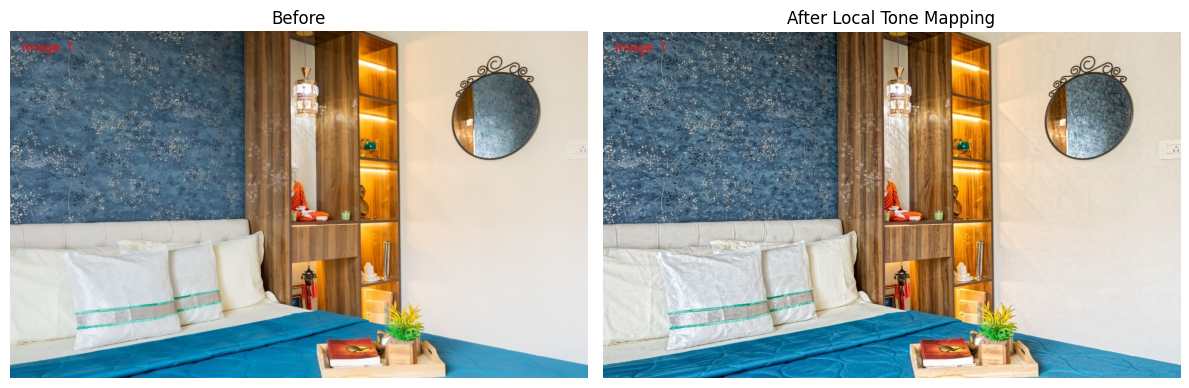

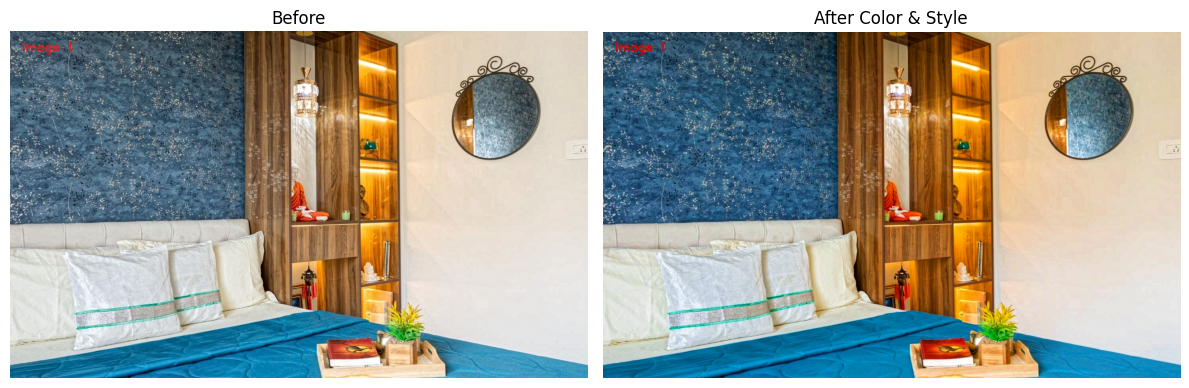

Image detected as good. Applying gentle enhancement...


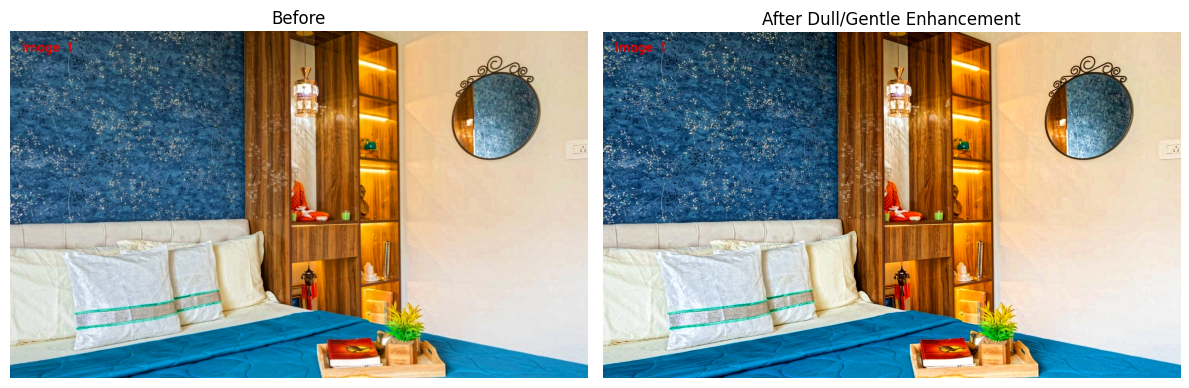

Image does not match white-dominant type. Skipping white balance correction.


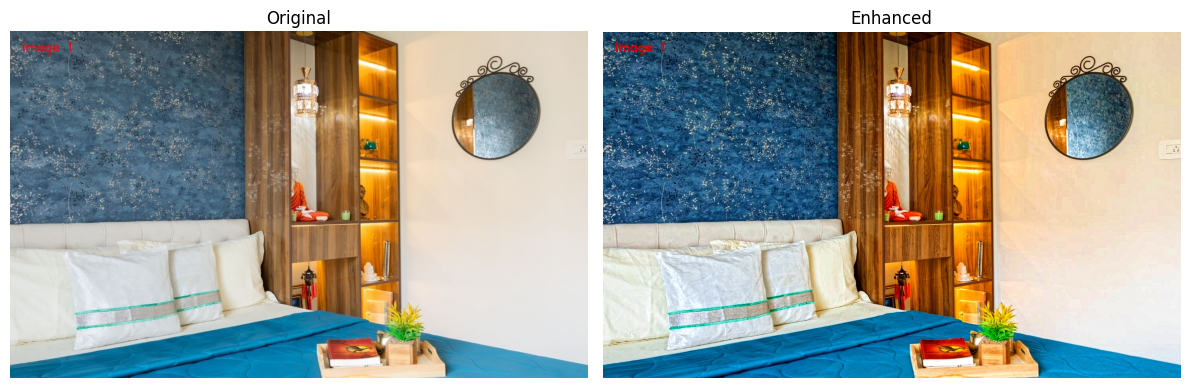

Enhanced image saved at: D:/AutoEnhnace/enhanced\enhanced_with_final_touch_numbered_1.jpg


In [33]:
# -------------------- Example Usage --------------------------
if __name__ == "__main__":
    image_path = r"IMAGE_FOLDER_PATH"  
    enhance_and_show_full_pipeline(image_path)
